# Importamos

In [141]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

import pandas as pd 
import numpy as np
import sklearn as sk
import seaborn as sns
import pydotplus
from six import StringIO
from IPython.display import Image  
from matplotlib import pyplot as plt
from dict_paises import COUNTRY_ALPHA3_TO_COUNTRY_ALPHA2, COUNTRY_ALPHA2_TO_CONTINENT
from joblib import dump, load
from os.path import exists
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import confusion_matrix, classification_report , f1_score, make_scorer, precision_score, recall_score, accuracy_score,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

#Si estamos  en colab tenemos que instalar la libreria "dtreeviz" aparte. 
if IN_COLAB == True:
    !pip install 'dtreeviz'
import dtreeviz as dtreeviz

#Para eliminar los warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from advertencia import ADVERTENCIA #Borrar cuando entreguemos

In [2]:
# Constantes
JOBS=-2
SEED=9

## Cargamos el dataframe de testeo

In [3]:
hotelsdf_pruebasOriginal = pd.read_csv("./hotels_test.csv")
hotelsdf_pruebas = hotelsdf_pruebasOriginal.copy()

# Adaptación de los datos al modelo

Ajustamos los datos encontrados en los datasets de manera conveniente para el analisis posterior con los modelos de ensambles

## Cargamos nuestro dataframe previamente analizado

Vamos a crear una copia de nuestro dataframe

In [4]:
hotelsdf_analizado = pd.read_csv("./dataframeCheckpoint1.csv")
hotelsdf_modelo = hotelsdf_analizado.copy()
print("El data frame esta compuesto por "f"{hotelsdf_modelo.shape[0]}"" filas y "f"{hotelsdf_modelo.shape[1]}"" columnas")

El data frame esta compuesto por 56883 filas y 33 columnas


Un vistazo básico a la información contenida en el dataframe:

In [5]:
pd.concat([hotelsdf_modelo.head(2), hotelsdf_modelo.sample(5), hotelsdf_modelo.tail(2)])

,Unnamed: 0,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,...,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled,dias_totales
0,0,City Hotel,49,2016,September,37,5,1,2,1,...,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1,3
1,1,Resort Hotel,4,2015,October,44,31,0,1,2,...,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0,1
28457,30963,City Hotel,15,2015,December,49,1,0,2,2,...,0,Transient,69.00,0,0,Canceled,2015-11-16,003e711a-d1e0-4701-9311-2f9dcfe02daa,1,2
24579,26751,Resort Hotel,3,2016,January,2,9,2,1,2,...,0,Transient,43.00,0,2,Check-Out,2016-01-12,fd793dc5-5db1-472d-942c-8ebe6c3eee55,0,3
52033,56647,City Hotel,239,2015,October,42,17,0,1,2,...,0,Transient,60.00,0,0,Canceled,2015-08-17,fd2898be-d397-48ba-acc0-ebdb33316040,1,1
43474,47334,City Hotel,226,2017,February,7,14,0,1,2,...,0,Transient,90.00,0,2,Canceled,2017-01-26,b3a4a69f-99ad-434e-b5df-9636f610e303,1,1
45279,49297,Resort Hotel,67,2017,May,21,27,2,2,2,...,0,Transient,115.00,0,2,Canceled,2017-04-08,8bf10f58-de14-47fe-a167-cdd40055323b,1,4
56881,61911,Resort Hotel,143,2015,October,41,10,2,5,2,...,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1,7
56882,61912,City Hotel,57,2016,April,17,17,2,5,2,...,0,Transient,143.29,0,0,Canceled,2016-04-09,7137e599-4442-41fb-b147-4aba9f344e38,1,7


Vemos que tenemos una columa extra "Unnamed: 0". Esta hace referencia la columna de origen del registro. Procedemos a borrarla

In [6]:
hotelsdf_modelo.drop("Unnamed: 0", axis=1, inplace=True)
hotelsdf_modelo.reset_index(drop=True)
print()

## Transformacion de las columnas

Para que los datos sean compatibles tomamos todas las columnas correspondientes a las variables cualitativas y procedemos a identificarlas:

In [7]:
valoresAConvertir = hotelsdf_modelo.dtypes[(hotelsdf_modelo.dtypes !='int64') & (hotelsdf_modelo.dtypes !='float64')].index
valoresAConvertir = valoresAConvertir.to_list()
valoresAConvertir

['hotel_name',
 'arrival_month',
 'meal_type',
 'country',
 'market_segment_type',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date',
 'booking_id']

Sin embargo, no todas estas columnas nos van a servir para nuestro analisis.

### Booking ID

Vamos a empezar removiendo booking\_id visto en como no la necesitamos para analisis

In [8]:
hotelsdf_modelo.drop("booking_id", axis=1, inplace=True)
hotelsdf_modelo.reset_index(drop=True)
valoresAConvertir.remove('booking_id')

### Reservation Status & Reservation status date

Reservation Status nos dice el estado de la reservacion, si fue cancelada o no y reservation status date nos marca la fecha en la que cambio el estado. 
Estas dos columnas nos son redundantes

In [9]:
hotelsdf_modelo.drop("reservation_status", axis=1, inplace=True)
hotelsdf_modelo.reset_index(drop=True)
valoresAConvertir.remove('reservation_status')

In [10]:
hotelsdf_modelo.drop("reservation_status_date", axis=1, inplace=True)
hotelsdf_modelo.reset_index(drop=True)
valoresAConvertir.remove('reservation_status_date')

### Country

Ajustamos los posibles valores que pueda tomar la variable country haciendo usos de diccionarios externos, con el proposito, de trabajar con el contienente de cada entrada

In [11]:
hotelsdf_modelo["continente"] = hotelsdf_modelo["country"].replace(COUNTRY_ALPHA3_TO_COUNTRY_ALPHA2)
hotelsdf_modelo["continente"] = hotelsdf_modelo["continente"].replace(COUNTRY_ALPHA2_TO_CONTINENT)

In [12]:
country = hotelsdf_modelo['country'].unique().tolist()
print(country) 

['USA', 'PRT', 'CHE', 'FRA', 'AGO', 'GBR', 'DEU', 'ESP', 'ROU', 'SWE', 'IRL', 'CN', 'ITA', 'NLD', 'NOR', 'MAR', 'BEL', 'ISR', 'KOR', 'IND', 'TUN', 'JPN', 'FIN', 'TUR', 'CHN', 'AUT', 'ZAF', 'LUX', 'BRA', 'POL', 'DNK', 'IRN', 'RUS', 'VEN', 'AUS', 'MLT', 'BGR', 'GEO', 'SRB', 'PHL', 'ARG', 'LVA', 'LTU', 'ARE', 'VNM', 'MOZ', 'THA', 'MEX', 'HUN', 'DZA', 'GAB', 'UKR', 'SVN', 'HRV', 'SVK', 'CHL', 'BLR', 'CPV', 'CRI', 'EST', 'TWN', 'ALB', 'SGP', 'IDN', 'DOM', 'MUS', 'OMN', 'EGY', 'SAU', 'NZL', 'FRO', 'CYP', 'PER', 'CZE', 'GRC', 'ARM', 'COL', 'PAK', 'MDG', 'HKG', 'MYS', 'MKD', 'ISL', 'BIH', 'NGA', 'AZE', 'MAC', 'JEY', 'SUR', 'KWT', 'BGD', 'IRQ', 'MDV', 'GGY', 'VGB', 'ECU', 'URY', 'ETH', 'LBN', 'BOL', 'QAT', 'JOR', 'COM', 'GNB', 'UGA', 'BEN', 'GIB', 'SEN', 'TZA', 'LBY', 'SYC', 'PRY', 'MNE', 'ZWE', 'CAF', 'ATA', 'MWI', 'JAM', 'AND', 'LIE', 'FJI', 'PRI', 'TJK', 'LKA', 'KAZ', 'HND', 'PAN', 'CMR', 'KEN', 'UMI', 'MYT', 'PYF', 'GLP', 'BRB', 'CIV', 'ZMB', 'CUB', 'TGO', 'SYR', 'SDN', 'NAM', 'GHA', 'GTM',

In [13]:
country = hotelsdf_modelo['continente'].unique().tolist()
print(country) 

['North America', 'Europe', 'Africa', 'Asia', 'South America', 'Oceania', 'ATA', 'UMI']


Observando el tratado de los datos identificamos nuevos outliers

"ATA" refiere al **continente** de Antartida. Al ser un valor tan fuera de lo comun y tener una sola ocurrencia decidimos eliminarlo del dataframe

In [14]:
hotelsdf_modelo.drop((hotelsdf_modelo[hotelsdf_modelo["country"] == "ATA"].index.values),inplace=True)
hotelsdf_modelo.reset_index(drop=True)
print()

"UMI" hace referenca a unas islas cerca de Hawaii. Al ser un unico caso y tener una poblacion de 300 habitantes, decidimos considerarlo como Estados Unidos, es decir America del Norte

Fuentes:
- https://www.iso.org/obp/ui/#iso:code:3166:UM
- https://en.wikipedia.org/wiki/United_States_Minor_Outlying_Islands

In [15]:
hotelsdf_modelo.loc[hotelsdf_modelo['country'] == "UMI", 'country'] = 'North America'
hotelsdf_modelo.loc[hotelsdf_modelo['continente'] == "UMI", 'continente'] = 'North America'

Con estos nuevos cambios, la columna continente toma los siguientes valores

In [16]:
continente = hotelsdf_modelo['continente'].unique().tolist()
print(continente) 

['North America', 'Europe', 'Africa', 'Asia', 'South America', 'Oceania']


Procedemos a dropear la columna de country

In [17]:
hotelsdf_modelo=hotelsdf_modelo.drop(['country'], axis='columns', inplace=False)
valoresAConvertir.remove('country')
valoresAConvertir.append('continente')
hotelsdf_modelo.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,deposit_type,agent_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,is_canceled,dias_totales,continente
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,No Deposit,9,0,Transient,115.50,0,1,1,3,North America
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,No Deposit,0,0,Transient,42.00,1,0,0,1,Europe
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,No Deposit,9,0,Transient,229.00,0,2,0,1,Europe
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,Non Refund,154,0,Transient,75.00,0,0,1,7,Europe
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,No Deposit,20,0,Transient-Party,75.00,0,1,0,7,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56877,Resort Hotel,24,2017,January,4,27,0,2,2,0,...,No Deposit,240,0,Transient,48.00,0,1,1,2,Europe
56878,City Hotel,0,2016,September,36,2,0,1,1,0,...,No Deposit,0,0,Transient,149.00,0,0,0,1,Europe
56879,City Hotel,10,2017,May,19,8,1,2,1,0,...,No Deposit,0,0,Transient,95.00,0,0,0,3,Europe
56880,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,Non Refund,96,0,Transient,36.05,0,0,1,7,Europe


In [18]:
valoresAConvertir

['hotel_name',
 'arrival_month',
 'meal_type',
 'market_segment_type',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'continente']

## One hot encoding

Aplicamos la tecnica de one hot encodig para hacer el dataset compatible con los modelos

In [19]:
hotelsdf_modelo = pd.get_dummies(hotelsdf_modelo, columns=valoresAConvertir, drop_first=True)

Vamos a observar como nos quedo el dataframe despues del one hot encoding

In [20]:
hotelsdf_modelo.head()

,lead_time,arrival_year,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,babies_num,is_repeated_guest,...,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,continente_Asia,continente_Europe,continente_North America,continente_Oceania,continente_South America
0,49,2016,37,5,1,2,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,4,2015,44,31,0,1,2,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,25,2016,42,13,0,1,2,2,0,0,...,0,0,0,1,0,0,1,0,0,0
3,26,2016,51,12,2,5,2,0,0,0,...,1,0,0,1,0,0,1,0,0,0
4,104,2017,12,19,2,5,2,0,0,0,...,0,0,0,0,1,0,1,0,0,0


Observamos que hay una **gran** cantidad de columnas

### Ajuste del dataset de pruebas

Tratamos de la misma manera al dataset de pruebas para hacerlo compatible con el modelo

Empezamos cambiando el nombre de las columnas para que coincida con el de nuestro dataframe

In [21]:
nuevas_columnas = {
    'adr':'average_daily_rate',
    'adults':'adult_num',
    'agent':'agent_id',
    'arrival_date_day_of_month':'arrival_month_day',
    'arrival_date_month':'arrival_month',
    'arrival_date_week_number':'arrival_week_number',
    'arrival_date_year':'arrival_year',
    'assigned_room_type':'assigned_room_type',
    'babies':'babies_num',
    'booking_changes':'booking_changes_num',
    'children':'children_num',
    'company':'company_id',
    'country':'country',
    'customer_type':'customer_type',
    'days_in_waiting_list':'days_in_waiting_list',
    'deposit_type':'deposit_type',
    'distribution_channel':'distribution_channel',
    'hotel':'hotel_name',
    'id':'booking_id',
    'is_repeated_guest':'is_repeated_guest',
    'lead_time':'lead_time',
    'market_segment':'market_segment_type',
    'meal':'meal_type',
    'previous_bookings_not_canceled':'previous_bookings_not_canceled_num',
    'previous_cancellations':'previous_cancellations_num',
    'required_car_parking_spaces':'required_car_parking_spaces_num',
    'reserved_room_type':'reserved_room_type',
    'stays_in_weekend_nights':'weekend_nights_num',
    'stays_in_week_nights':'week_nights_num',
    'total_of_special_requests':'special_requests_num',
}

hotelsdf_pruebas.rename(columns = nuevas_columnas, inplace = True)

Procesamos datos faltantes

#### Dias Totales

Añadimos la columna agregada en el analisis exploratorio previo

In [22]:
hotelsdf_pruebas["dias_totales"] = hotelsdf_pruebas["week_nights_num"] + hotelsdf_pruebas["weekend_nights_num"]

#### Datos faltantes

In [23]:
hotelsdf_pruebas.isnull().sum()

hotel_name                                0
lead_time                                 0
arrival_year                              0
arrival_month                             0
arrival_week_number                       0
arrival_month_day                         0
weekend_nights_num                        0
week_nights_num                           0
adult_num                                 0
children_num                              0
babies_num                                0
meal_type                                 0
country                                  95
market_segment_type                       0
distribution_channel                      0
is_repeated_guest                         0
previous_cancellations_num                0
previous_bookings_not_canceled_num        0
reserved_room_type                        0
assigned_room_type                        0
booking_changes_num                       0
deposit_type                              0
agent_id                        

In [24]:
print("Vemos que 'company id' tiene un " + str( (hotelsdf_pruebas["company_id"].isnull().sum() * 100) / len(hotelsdf_pruebas)  ) + "% de datos faltantes.")
print("Por esto decidimos eliminar la columna (tanto en el dataset de testeo como en el de entrenamiento)")

Vemos que 'company id' tiene un 95.03674392312041% de datos faltantes.
Por esto decidimos eliminar la columna (tanto en el dataset de testeo como en el de entrenamiento)


In [25]:
hotelsdf_pruebas.drop("company_id", axis=1, inplace=True)
hotelsdf_pruebas.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,deposit_type,agent_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status_date,booking_id,dias_totales
0,City Hotel,277,2016,November,46,7,1,2,2,0.0,...,Non Refund,NaN,0,Transient,100.00,0,0,2016-04-04,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,3
1,City Hotel,286,2016,May,20,11,0,4,2,0.0,...,No Deposit,30.0,176,Transient-Party,101.00,0,0,2016-01-22,aba9aac2-4495-4645-a60e-90328713c999,4
2,City Hotel,0,2016,August,35,23,0,1,3,0.0,...,No Deposit,NaN,0,Transient,225.00,0,2,2016-08-24,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,1
3,Resort Hotel,196,2016,October,44,29,2,5,2,2.0,...,No Deposit,240.0,0,Transient,96.00,0,0,2016-11-05,ce1b400e-afa1-4946-bdff-004b859eb61c,7
4,Resort Hotel,232,2016,November,48,26,2,1,2,0.0,...,Non Refund,11.0,0,Transient,30.00,0,0,2016-10-18,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26530,City Hotel,31,2017,April,16,21,2,3,2,0.0,...,No Deposit,21.0,0,Transient-Party,85.00,0,0,2017-04-26,636ccded-66ad-4538-8006-c0b9f84c6256,5
26531,City Hotel,130,2016,September,36,3,2,1,2,0.0,...,No Deposit,42.0,0,Transient,80.75,0,0,2016-09-06,11e19741-bd28-4459-8ea3-184f1664000f,3
26532,Resort Hotel,45,2016,August,35,22,1,1,2,0.0,...,No Deposit,240.0,0,Transient,231.00,0,0,2016-08-04,36a4c7b0-d6b1-4528-93db-311be96ec1c6,2
26533,City Hotel,164,2017,August,32,10,2,4,2,0.0,...,No Deposit,85.0,0,Transient,80.10,0,0,2017-03-07,89c85fa5-2b3d-4131-844c-e151a65ca240,6


### Valores a convertir

De ser posible aplicamos el cirterio anterior

In [26]:
valores_a_convertir_pruebas = hotelsdf_pruebas.dtypes[(hotelsdf_pruebas.dtypes !='int64') & (hotelsdf_pruebas.dtypes !='float64')].index
valores_a_convertir_pruebas = valores_a_convertir_pruebas.to_list()
valores_a_convertir_pruebas

['hotel_name',
 'arrival_month',
 'meal_type',
 'country',
 'market_segment_type',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status_date',
 'booking_id']

#### Booking ID

In [27]:
hotelsdf_pruebas.drop("booking_id", axis=1, inplace=True)
hotelsdf_pruebas.reset_index(drop=True)
valores_a_convertir_pruebas.remove('booking_id')

#### Agent ID

Tomamos el mismo criterio que el checkpoint 1. Transformamos a 0

In [28]:
hotelsdf_pruebas.loc[hotelsdf_pruebas['agent_id'].isnull(), 'agent_id'] = 0

#### Reservation Status & Reservation status date

Dropeamos estas columnas debido a que no nos dan ninguna informacion adicional

In [29]:
hotelsdf_pruebas.drop("reservation_status_date", axis=1, inplace=True)
hotelsdf_pruebas.reset_index(drop=True)
valores_a_convertir_pruebas.remove('reservation_status_date')

#### Country y Continents

Para los valores faltantes de la columna country aplicamos el criterio del analisis exploratorio y los cambiamos por Portugal

In [30]:
hotelsdf_pruebas.loc[hotelsdf_pruebas['country'].isnull(), 'country'] = 'PRT'

In [31]:
hotelsdf_pruebas["continente"] = hotelsdf_pruebas["country"].replace(COUNTRY_ALPHA3_TO_COUNTRY_ALPHA2)
hotelsdf_pruebas["continente"] = hotelsdf_pruebas["continente"].replace(COUNTRY_ALPHA2_TO_CONTINENT)

In [32]:
country = hotelsdf_pruebas['country'].unique().tolist()
valores_a_convertir_pruebas.append("continente")
print(country) 

['PRT', 'FRA', 'DEU', 'CN', 'GBR', 'ITA', 'IRL', 'USA', 'ESP', 'SWE', 'RWA', 'NLD', 'AUT', 'AUS', 'RUS', 'CHE', 'CHN', 'DNK', 'POL', 'BEL', 'BRA', 'TUR', 'NOR', 'EST', 'ISL', 'VEN', 'ISR', 'JPN', 'MAR', 'ATF', 'HRV', 'IRN', 'LTU', 'FIN', 'PER', 'LVA', 'KOR', 'LUX', 'JAM', 'HUN', 'DZA', 'TWN', 'ZWE', 'THA', 'ROU', 'IND', 'ARG', 'CHL', 'MEX', 'ARE', 'MOZ', 'SAU', 'URY', 'ECU', 'GRC', 'UZB', 'AGO', 'GIB', 'CZE', 'ZAF', 'TUN', 'TJK', 'BGR', 'COL', 'SRB', 'EGY', 'VNM', 'CYP', 'OMN', 'NZL', 'SUR', 'SVK', 'LBY', 'SGP', 'LBN', 'BLR', 'SEN', 'HKG', 'MDV', 'UKR', 'BIH', 'IDN', 'MAC', 'KWT', 'JOR', 'SLV', 'MYS', 'DMA', 'CMR', 'PHL', 'ASM', 'MLT', 'BGD', 'SVN', 'GHA', 'JEY', 'NGA', 'MCO', 'CPV', 'PAK', 'TZA', 'KAZ', 'BOL', 'DJI', 'QAT', 'IRQ', 'GNB', 'IMN', 'DOM', 'LIE', 'PRI', 'CUB', 'TMP', 'BHR', 'MKD', 'CAF', 'ALB', 'AND', 'MWI', 'PRY', 'LKA', 'GEO', 'CRI', 'UGA', 'GGY', 'ATA', 'SMR', 'BFA', 'MLI', 'BRB', 'GLP', 'KHM', 'STP', 'GAB', 'NIC']


In [33]:
continentes = hotelsdf_pruebas['continente'].unique().tolist()
print(continentes) 

['Europe', 'Asia', 'North America', 'Africa', 'Oceania', 'South America', 'ATF', 'ATA']


Tal como ocurrio con el dataset de Train, observamos que hay algunos continente (y por tanto sus paises y registros asociados) que parecen ser outliers.
Los estudiamos

In [34]:
hotelsdf_pruebas[ hotelsdf_pruebas['continente'] =="ATA"]

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,booking_changes_num,deposit_type,agent_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,dias_totales,continente
17499,City Hotel,34,2016,October,42,13,0,2,1,0.0,...,0,No Deposit,14.0,0,Transient,175.5,0,0,2,ATA


Hay un registro correspondiente a "Antartida". como no podemos dropearlo, le ponemos de continente "north america".\
Le asignamos el valor de America del norte debido a que estados unidos es el pais con mas bases en la antartica

In [35]:
hotelsdf_pruebas.loc[hotelsdf_pruebas['continente'] == "ATA", 'continente'] = "North America"

In [36]:
hotelsdf_pruebas[ hotelsdf_pruebas['continente'] =="ATF"]

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,booking_changes_num,deposit_type,agent_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,dias_totales,continente
401,City Hotel,116,2017,July,27,2,2,0,2,0.0,...,0,No Deposit,9.0,0,Transient,126.0,0,0,2,ATF


"ATF", que es la sigla de Fr. So. Ant. Tr (French southern and antartic lands).
Ponemos su contienente en Europa. 

In [37]:
hotelsdf_pruebas.loc[hotelsdf_pruebas['continente'] == "ATF", 'continente'] = "Europe"

In [38]:
hotelsdf_pruebas[hotelsdf_pruebas['continente'] =="ATF"]

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,booking_changes_num,deposit_type,agent_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,dias_totales,continente


#### Analisis de valores faltantes de continente

In [39]:
hotelsdf_pruebas[hotelsdf_pruebas['continente'].isna()]

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,booking_changes_num,deposit_type,agent_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,dias_totales,continente


Vemos que hay una serie de registros que no tienen el dato del pais. Sin embargo, no son muchos. Debido a esto, vamos a asignarle estos registros el valor de aquel contiente que tenga la mayor cantidad de registros

Text(0, 0.5, 'Cantidad de registros')

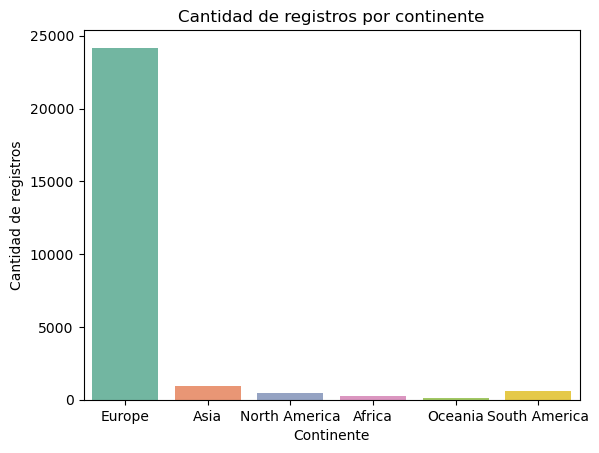

In [40]:
sns.countplot(data = hotelsdf_pruebas, x = 'continente', palette= 'Set2')
plt.title('Cantidad de registros por continente')
plt.xlabel('Continente')
plt.ylabel('Cantidad de registros')

Vemos que el continente con mayor cantidad de registros es europa, asique lo asignamos a ese valor

In [41]:
hotelsdf_pruebas.loc[hotelsdf_pruebas['continente'].isnull(), 'country'] = 'Europe'

Miro q se hayan cambiado bien todos los continentes y no haya valores raros

In [42]:
continentes = hotelsdf_pruebas['continente'].unique().tolist()
print(continentes)

['Europe', 'Asia', 'North America', 'Africa', 'Oceania', 'South America']


Como hicimos con el dataset de train, y ya habiendo procesado la columna continente, dropeamos la columna country

In [43]:
hotelsdf_pruebas=hotelsdf_pruebas.drop(['country'], axis='columns', inplace=False)
hotelsdf_pruebas.reset_index(drop=True)
valores_a_convertir_pruebas.remove('country')

#### previous bookings not cancelled

Al igual q en el train, dropeamos esta col

In [44]:
hotelsdf_pruebas=hotelsdf_pruebas.drop(['previous_bookings_not_canceled_num'], axis='columns', inplace=False)
hotelsdf_pruebas.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,booking_changes_num,deposit_type,agent_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,dias_totales,continente
0,City Hotel,277,2016,November,46,7,1,2,2,0.0,...,0,Non Refund,0.0,0,Transient,100.00,0,0,3,Europe
1,City Hotel,286,2016,May,20,11,0,4,2,0.0,...,0,No Deposit,30.0,176,Transient-Party,101.00,0,0,4,Europe
2,City Hotel,0,2016,August,35,23,0,1,3,0.0,...,0,No Deposit,0.0,0,Transient,225.00,0,2,1,Europe
3,Resort Hotel,196,2016,October,44,29,2,5,2,2.0,...,0,No Deposit,240.0,0,Transient,96.00,0,0,7,Europe
4,Resort Hotel,232,2016,November,48,26,2,1,2,0.0,...,0,Non Refund,11.0,0,Transient,30.00,0,0,3,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26530,City Hotel,31,2017,April,16,21,2,3,2,0.0,...,0,No Deposit,21.0,0,Transient-Party,85.00,0,0,5,Europe
26531,City Hotel,130,2016,September,36,3,2,1,2,0.0,...,0,No Deposit,42.0,0,Transient,80.75,0,0,3,Europe
26532,Resort Hotel,45,2016,August,35,22,1,1,2,0.0,...,0,No Deposit,240.0,0,Transient,231.00,0,0,2,Europe
26533,City Hotel,164,2017,August,32,10,2,4,2,0.0,...,0,No Deposit,85.0,0,Transient,80.10,0,0,6,Europe


In [45]:
hotelsdf_pruebas.isnull().sum()

hotel_name                         0
lead_time                          0
arrival_year                       0
arrival_month                      0
arrival_week_number                0
arrival_month_day                  0
weekend_nights_num                 0
week_nights_num                    0
adult_num                          0
children_num                       0
babies_num                         0
meal_type                          0
market_segment_type                0
distribution_channel               0
is_repeated_guest                  0
previous_cancellations_num         0
reserved_room_type                 0
assigned_room_type                 0
booking_changes_num                0
deposit_type                       0
agent_id                           0
days_in_waiting_list               0
customer_type                      0
average_daily_rate                 0
required_car_parking_spaces_num    0
special_requests_num               0
dias_totales                       0
c

### One hot encoding del testeo

De la misma manera al dataset de pruebas aplicamos one hot encoding sobre las columnas de variables cualitativas

In [46]:
hotelsdf_pruebas = pd.get_dummies(hotelsdf_pruebas, columns=valores_a_convertir_pruebas, drop_first=True)
hotelsdf_pruebas.head()

,lead_time,arrival_year,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,babies_num,is_repeated_guest,...,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,continente_Asia,continente_Europe,continente_North America,continente_Oceania,continente_South America
0,277,2016,46,7,1,2,2,0.0,0,0,...,1,0,0,1,0,0,1,0,0,0
1,286,2016,20,11,0,4,2,0.0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,2016,35,23,0,1,3,0.0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,196,2016,44,29,2,5,2,2.0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,232,2016,48,26,2,1,2,0.0,0,0,...,1,0,0,1,0,0,1,0,0,0


### Corroboracion de columnas

Despues de todas estas transformaciones vamos a corrobar que los dataframes tengan la misma cantidad de columnas.

In [47]:
set_test = set(hotelsdf_pruebas.columns)
set_modelo = set(hotelsdf_modelo.columns)

missing = list(sorted(set_test - set_modelo))
added = list(sorted(set_modelo - set_test))

print('Faltan en arbol:', missing)
print('Sobran en arbol:', added)

Faltan en arbol: ['assigned_room_type_P', 'reserved_room_type_L', 'reserved_room_type_P']
Sobran en arbol: ['is_canceled']


Vemos que en el dataframe del arbol nos sobra la columna "is canceled", cosa que hace sentido ya que esa es la columna con la que vamos a entrenar al dataset. Sin embargo, vemos que tambien hay 3 columnas que faltan en el dataset de arbol. 

Vamos a reasignar los valores de las columnas de test para que coincidan.

El siguiente codigo nos calcula cuantas personas tiene cada tipo de cuarto

In [48]:
cant_cuartos = {}
cant_casos_sumado = 0

cant_cuartos["A"] = 0 #Arrancamos asignado 0 a los cuartos de A. Estos fueron removidos por el one hot. Lo vamos a calcular al final.
for letra in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']:
    tipo_cuarto = 'reserved_room_type_' + letra
    cant_casos_sumado += 1
    if tipo_cuarto not in hotelsdf_pruebas.columns:
        continue
    hotelsdf_pruebas[tipo_cuarto]
    resultado = hotelsdf_pruebas[hotelsdf_pruebas[tipo_cuarto] == 1][tipo_cuarto].sum()
    cant_cuartos[letra] = resultado

cuartosA = len(hotelsdf_pruebas) - cant_casos_sumado
cant_cuartos["A"] = cuartosA


cant_cuartos

{'A': 26509,
 'B': 241,
 'C': 202,
 'D': 4176,
 'E': 1352,
 'F': 630,
 'G': 442,
 'H': 118,
 'L': 3,
 'P': 5}

Vemos que L y P tienen una extremadamente pequena cantidad de apariciones. \
Lo vamos a anadir al roomtype A al ser el que tiene la mayor cantidad de apariciones.

Para anadirlos a la columna a, simplemente tenemos que eliminar las columnas L y P (ya que la columna A es la eliminada por el one hot)

In [49]:
hotelsdf_pruebas.drop("reserved_room_type_L", axis=1, inplace=True)
hotelsdf_pruebas.drop("reserved_room_type_P", axis=1, inplace=True)
hotelsdf_pruebas.reset_index(drop=True)
print()

Vamos a aplicar el mismo criterio a assigned room type

In [50]:
cant_cuartos = {}
cant_casos_sumado = 0

cant_cuartos["A"] = 0 #Arrancamos asignado 0 a los cuartos de A. Estos fueron removidos por el one hot. Lo vamos a calcular al final.
for letra in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']:
    tipo_cuarto = 'assigned_room_type_' + letra
    cant_casos_sumado += 1
    if tipo_cuarto not in hotelsdf_pruebas.columns:
        continue
    hotelsdf_pruebas[tipo_cuarto]
    resultado = hotelsdf_pruebas[hotelsdf_pruebas[tipo_cuarto] == 1][tipo_cuarto].sum()
    cant_cuartos[letra] = resultado

cuartosA = len(hotelsdf_pruebas) - cant_casos_sumado
cant_cuartos["A"] = cuartosA


cant_cuartos

{'A': 26509,
 'B': 439,
 'C': 445,
 'D': 5316,
 'E': 1576,
 'F': 764,
 'G': 517,
 'H': 135,
 'I': 66,
 'K': 54,
 'P': 5}

Aca tambien vemos que P tiene muy pocas aparciones. Asique aplicamos el mismo criterio de antes

In [51]:
hotelsdf_pruebas.drop("assigned_room_type_P", axis=1, inplace=True)
hotelsdf_pruebas.reset_index(drop=True)
print()

Vemos ahora que nuestras columnas coinciden

In [52]:
set_test = set(hotelsdf_pruebas.columns)
set_modelo = set(hotelsdf_modelo.columns)

missing = list(sorted(set_test - set_modelo))
added = list(sorted(set_modelo - set_test))

print('Faltan en arbol:', missing)
print('Sobran en arbol:', added)

Faltan en arbol: []
Sobran en arbol: ['is_canceled']


# Generacion de datos para el entrenamiento de los modelos

Se genera un dataset con los datos necesarios para predecir la cancelacion y creamos un dataset conteniendo el target, para luego, generar conjuntos de test y train

In [53]:
hotelsdf_modelo_x=hotelsdf_modelo.drop(['is_canceled'], axis='columns', inplace=False)

hotelsdf_modelo_y = hotelsdf_modelo['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(hotelsdf_modelo_x,
                                                    hotelsdf_modelo_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=SEED) #Semilla 9, como el Equipo !!

# KNN

Entrenamos un primer modelo de KNN usando los datos previamente tratados

## KNN base

En primera instancia entrenamos un modelo sin optimizar hiperparametros, de manera que, se obtiene una medida de la predicción base que tiene el modelo.

Creamos el modelo y lo entrenamos:

In [54]:
if not exists('modelos/knn_base.joblib'):
    knn_base = KNeighborsClassifier()
    knn_base.get_params()
    knn_base.fit(x_train, y_train)
    dump(knn_base, 'modelos/knn_base.joblib')
else:
    knn_base = load('modelos/knn_base.joblib')

In [55]:
y_pred = knn_base.predict(x_test)

Observamos el comportamiento del modelo base

In [56]:
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  12382
total:  17065


Observamos mediante la matriz de confusion el comportamiento del modelo base con los datos de prueba 

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      8499
           1       0.73      0.73      0.73      8566

    accuracy                           0.73     17065
   macro avg       0.73      0.73      0.73     17065
weighted avg       0.73      0.73      0.73     17065



Text(50.722222222222214, 0.5, 'Verdadero')

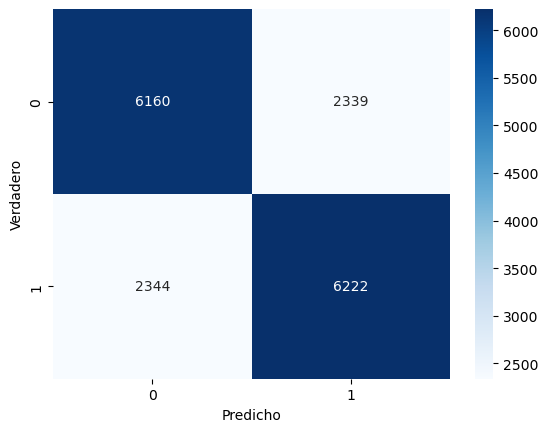

In [57]:
print(classification_report(y_test,y_pred))

confusion_knn_base = confusion_matrix(y_test,y_pred)
sns.heatmap(confusion_knn_base, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

Basado en el grafico, es posible observar que el modelo base ha obtenido un desempeño moderado en los datos de prueba a pesar de no haber recibido ningun tipo de optimización 

Generamos una prediccón para kaggle con el modelo base

In [58]:
if not exists('submissions/knn_base.csv'):
    y_pred = knn_base.predict(hotelsdf_pruebas)
    df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': y_pred})
    df_submission.to_csv('submissions/knn_base.csv', index=False)

## Busqueda de hiperparametros

### Modificar los k vecinos

Realizamos una busqueda de cuales son los valores de k para los cuales el modelo tiene un mejor desempeño 

In [59]:
metricas = []
cant_vecinos = range(1, 30) 

if not exists('modelos/metricas.joblib'):
    for n in cant_vecinos:
        knn = KNeighborsClassifier(n_neighbors = n, n_jobs=JOBS)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        metricas.append( (n, (y_test == y_pred).sum())) 
else:
    metricas = load('modelos/metricas.joblib')

De la prueba anterior observamos el comportamiento que tiene 

<Figure size 600x500 with 0 Axes>

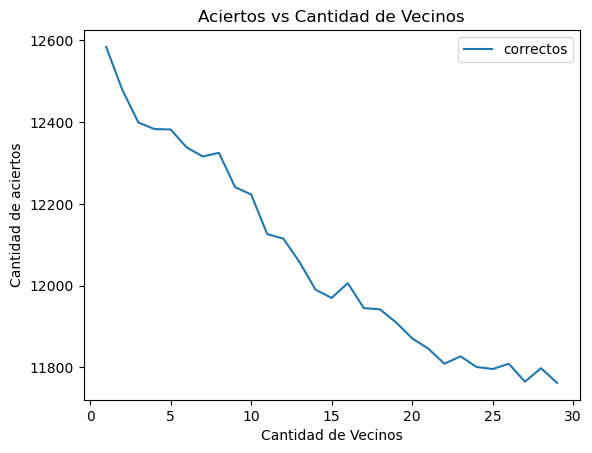

In [60]:
plt.figure(figsize = (6,5))

df_metrics = pd.DataFrame(metricas, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                    )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

Por otro lado observamos el comportamiento de la presicion 

In [61]:
knn_metricas = []

if not exists('modelos/knn_metricas.joblib'):
    for n in cant_vecinos:
      knn = KNeighborsClassifier(n_neighbors = n)
      scores=cross_val_score(knn,x_train,y_train,cv=10,scoring='accuracy')
      knn_metricas.append(scores.mean())
    dump(knn_metricas, 'modelos/knn_metricas.joblib')
else:
    knn_metricas = load('modelos/knn_metricas.joblib')

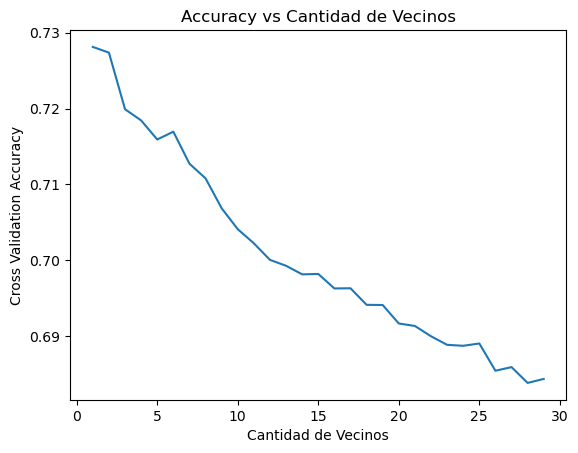

In [62]:
plt.plot(cant_vecinos, knn_metricas)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation Accuracy')
plt.title('Accuracy vs Cantidad de Vecinos')
plt.show()

Podemos concluir de las graficas anteriores que el modelo tiende a empeorar a medida que aumentan la cantidad de vecinos, de todos modos la variación de la presión es considerablemente pequeña. Por lo tanto consideraremos el mismo rango de valores a la hora de realizar el cross validation search

### Random search cross validation

Buscamos la mejor combinación de hiperparametros con la intención de mejorar las metricas del modelo y a su vez mejorar la performance del mismo

In [63]:
combinaciones = 10
k_folds = 10
metrica_fn = make_scorer(sk.metrics.f1_score)

if not exists('modelos/RCV_knn.joblib'):

  params_grid={ 'n_neighbors':range(1,15), 
                'weights':['distance','uniform'],
                'algorithm':['ball_tree', 'kd_tree'],
                'metric':['euclidean','manhattan']}

  knn_optimizado = KNeighborsClassifier()
  parametros = RandomizedSearchCV(
              estimator=knn_optimizado, 
              param_distributions = params_grid, 
              cv=k_folds, 
              scoring=metrica_fn, 
              n_iter=combinaciones, 
              random_state=9)
  parametros.fit(x_train, y_train)
  parametros.cv_results_['mean_test_score']
  dump(parametros, 'modelos/RCV_knn.joblib')
else:
    parametros = load('modelos/RCV_knn.joblib')

Observamos el comportamiento de los mejores hiperparamtros encontrados 

In [64]:
print(parametros)
print(parametros.best_params_)
print(parametros.best_score_)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree'],
                                        'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': range(1, 15),
                                        'weights': ['distance', 'uniform']},
                   random_state=9, scoring=make_scorer(f1_score))
{'weights': 'distance', 'n_neighbors': 10, 'metric': 'manhattan', 'algorithm': 'ball_tree'}
0.7696174482953996


Creamos y entrenamos el modelo con los mejores imperparametros 

In [65]:
if not exists('modelos/knn_optimizado.joblib'):
  knn_optimizado = KNeighborsClassifier(**parametros.best_params_)
  knn_optimizado.fit(x_train, y_train)
  dump('modelos/knn_optimizado.joblib')
else:
    knn_optimizado = load('modelos/knn_optimizado.joblib')

## Cross validation

Verificamos la eficacia del modelo y sus hiperparametros mediante la validación cruzada

In [66]:
kfoldcv =StratifiedKFold(n_splits=k_folds) 
resultados_knn = cross_validate(knn_optimizado, x_train, y_train, cv=kfoldcv,scoring=metrica_fn,return_estimator=True)
metricas_knn = resultados_knn['test_score']
knn_optimizado = resultados_knn['estimator'][np.where(metricas_knn==max(metricas_knn))[0][0]]

Observamos la distribucion de la metrica f1 a lo largo de los entrenamientos

Text(0.5, 1.0, 'Modelo entrenado con 10 folds')

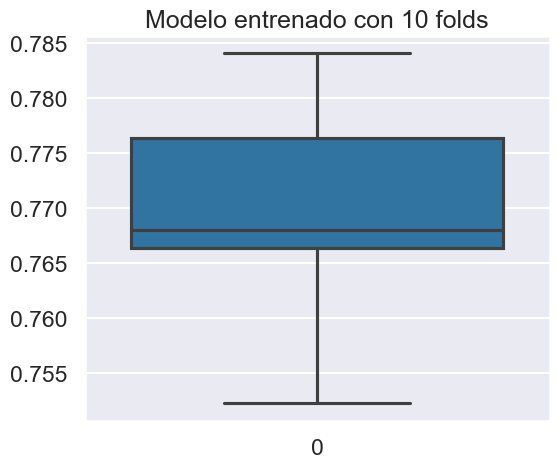

In [67]:
metric_labelsCV = ['F1 Score']*len(metricas_knn) 
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(6,5))
sns.boxplot(metricas_knn)
plt.title("Modelo entrenado con 10 folds")

Mostramos la matriz de confusión del modelo y observamos su desempeño global

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      8499
           1       0.75      0.79      0.77      8566

    accuracy                           0.76     17065
   macro avg       0.76      0.76      0.76     17065
weighted avg       0.76      0.76      0.76     17065

F1-Score: 0.769932182139397


Text(37.08333333333333, 0.5, 'verdadero')

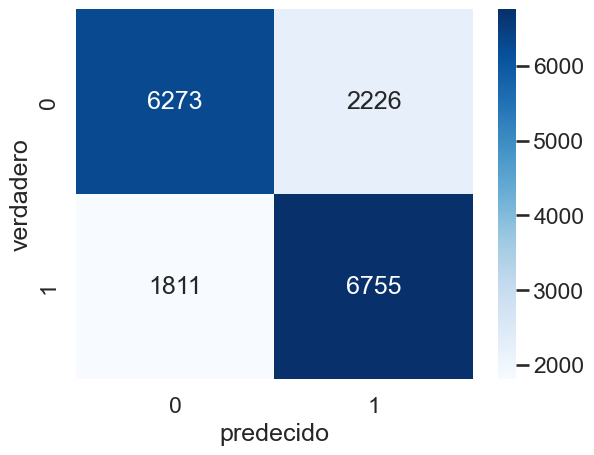

In [68]:
y_pred= knn_optimizado.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) 
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('predecido')
plt.ylabel('verdadero')

Una vez entrenado y guardado el modelo generamos una predicción para kaggle.

In [69]:
y_pred = knn_optimizado.predict(hotelsdf_pruebas)
df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': y_pred})

if not exists('submissions/knn_optimizado.csv'):
    df_submission.to_csv('submissions/knn_optimizado.csv', index=False)

Si comparamos el desempeño del modelo tanto en ejecución del analisis como en las predicciones de kaggle podemos observar que el modelo optimizado presenta una mejoria de al menos 0.05 puntos a comparación del modelo base. Por otro lado, el modelo knn no presenta una mejora global al analisis hecho con un árbol de decisión

# SVM 





### Librerias y FuncionesPredecid`

In [70]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicho')
  plt.ylabel('Verdadero')

Hacemos un GridSeacrh para ver cual es el mejor kernel a utilizar.
OJO, TOMA 32 MIN aprox correrlo

In [71]:
if not exists('modelos/gridcv_svm_kernel.joblib'):
    parametros = { 'kernel': ["linear", "poly","rbf"]}


    clf_tres = SVC(random_state=9)

    scorer_fn = make_scorer(sk.metrics.f1_score)

    gridcv_svm_tres = GridSearchCV(estimator=clf_tres,
                                  param_grid= parametros,
                                  scoring=scorer_fn,
                                  n_jobs=JOBS #-1
                                  ) 

    #lo entreno sobre los datos
    gridcv_svm_tres.fit(x_train, y_train)

    print("Mostramos los mejores resultados: ")
    print(gridcv_svm_tres.best_params_)
    print()
    print("Mostramos el mejor resultado obtenido de busqueda aleatoria: ")
    print("f1_score: ",gridcv_svm_tres.best_score_)
    
    dump(gridcv_svm_tres, 'modelos/gridcv_svm_kernel.joblib')

In [72]:
gridcv_svm_kernel = load('modelos/gridcv_svm_kernel.joblib')

Obtenemos que el mejor Kernel es el linel con un f1_score de 0,75.

A continuacion, probamos igualmente los 3 Kernels para ver si podemos obtener alguna optimizacion o mejora del valor anterior

### Modifico Kernels para ver cual se adapta mejor

### Lineal 

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      8499
           1       0.76      0.73      0.75      8566

    accuracy                           0.75     17065
   macro avg       0.75      0.75      0.75     17065
weighted avg       0.75      0.75      0.75     17065



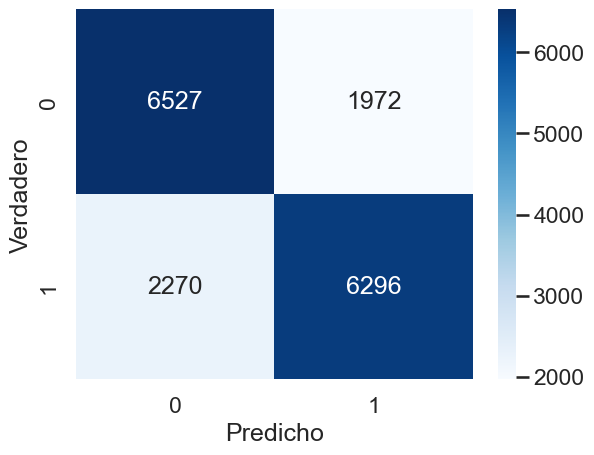

In [73]:
if not exists('modelos/svm_lineal_mejor_performance.joblib'):
    #Creo un clasificador con kernel lineal y lo entreno
    svm_lineal_mejor_performance = SVC(kernel='linear', C=5, random_state=9)
    svm_lineal_mejor_performance.fit(x_train, y_train)

    #Hago la predicción y calculo las métricas
    y_pred_lin=svm_lineal_mejor_performance.predict(x_test)
    metricas(y_pred_lin,y_test)

    dump(svm_lineal_mejor_performance, 'modelos/svm_lineal_mejor_performance.joblib')

else:
    svm_lineal_mejor_performance = load('modelos/svm_lineal_mejor_performance.joblib')
    y_pred_lin=svm_lineal_mejor_performance.predict(x_test)
    metricas(y_pred_lin,y_test)


Con el kernel lineal, obtebemos un f1_score relativamente bueno (casi -por no decir exactamente igual- al obtenido con el GridSearch antes) aunq no mejor que el obtenido con el decission tree en la entrega anterior.Intentamos cambiar su parametro C para ver si conseguimos alguna leve mejora (no lo elevamos demasiado porque ya sabemos que overfittea). Este proceso fue hecho a "fuerza bruta" ya que no encontramos la manera de correr un Random/Grid search para variar solo el parametro C. Se probo con valores de C = [1, 5, 7, 10, 15, 100] y con todos se obtuvo un f1_score muy similar. Optamos por el valor de 5 ya que lo esperado es que un valor de C mas bajo nos entregue un modelo mas generalizable.

Hago un entrenamiento con cross validation para ver que el modelo sea generalizable\

**ATENCION: 10 MIN con core i5 + 16Gb RAM (sin archivos de joblib)**

In [74]:
folds=5
scorer_fn = make_scorer(sk.metrics.f1_score)

if not exists('modelos/svm_lineal_mejor_performance.joblib'):
    kfoldcv = StratifiedKFold(n_splits=folds)
    resultados = cross_validate(svm_lineal_mejor_performance,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

    dump(resultados, 'modelos/resultados_cv_kernel_lineal.joblib')
else:
    resultados = load('modelos/resultados_cv_kernel_lineal.joblib')


In [75]:
metricsCV=resultados['test_score']

if not exists('modelos/svm_lineal_mejor_performance.joblib'):
    svm_lineal_mejor_performance=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]
    dump(svm_lineal_mejor_performance, 'modelos/svm_lineal_mejor_performance.joblib')

metricsCV

array([0.74744198, 0.76092157, 0.7484476 , 0.74758023, 0.76054236])

Text(0.5, 1.0, 'Modelo entrenado con 5 folds')

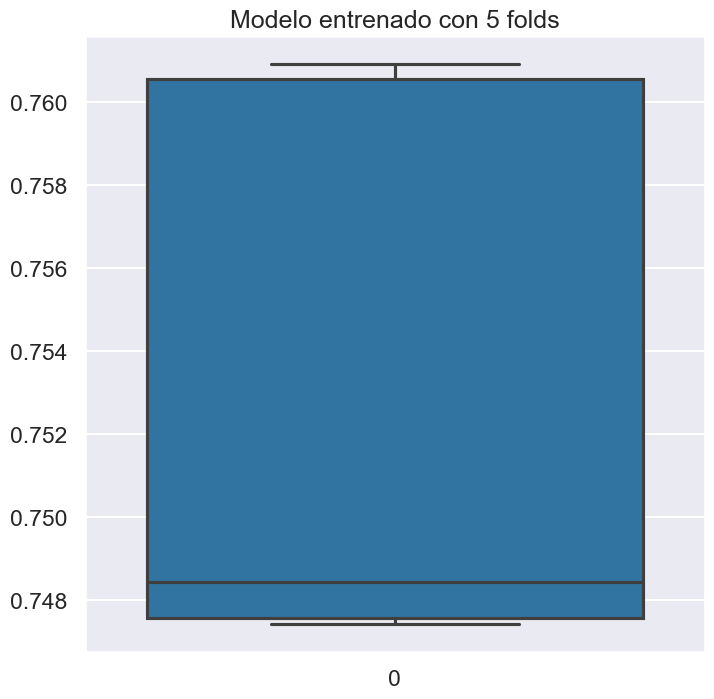

In [76]:
metric_labelsCV = ['F1 Score']*len(metricsCV) 
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(metricsCV)
plt.title("Modelo entrenado con 5 folds")

Se puede ver que no hay mucha variacion en los valores obtenidos por lo cual podemos concluir que es un modelo bueno para generalizar. A continuacion los resultados de probar con el dataset de testeo.

In [77]:
svm_lineal_mejor_performance = load('modelos/svm_lineal_mejor_performance.joblib')

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      8499
           1       0.76      0.73      0.75      8566

    accuracy                           0.75     17065
   macro avg       0.75      0.75      0.75     17065
weighted avg       0.75      0.75      0.75     17065

F1-Score: 0.7480099798027802


Text(37.08333333333333, 0.5, 'Verdadero')

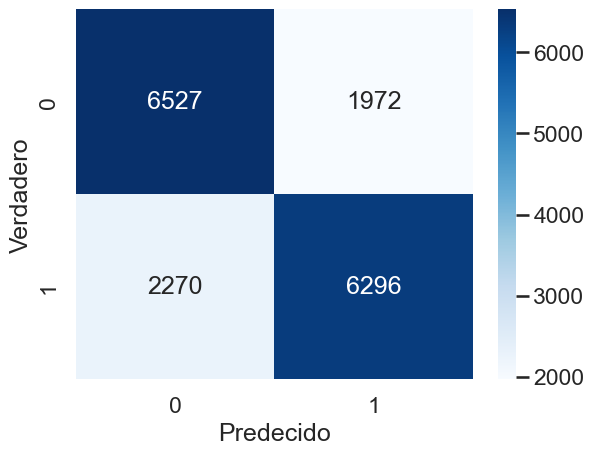

In [78]:
y_pred= svm_lineal_mejor_performance.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) 
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predecido')
plt.ylabel('Verdadero')

Se puede ver que si bien los resultados no son excelentes, son relativamente buenos (f1_score = 0,75). Lo esperado es que, segun lo estudiado en clase, recien al hacer los ensambles con varios estimadores mediocres -muy buena palabra- (un KNN, un SVM y un RF) obtendremos una mejora en el f1_score.

A continuacion deberiamos exportar el csv para submission a Kaggle. Puesto que no representaninguna mejora del score obtenido anteriormente no lo hacemos

In [79]:
if not exists('submissions/svm_lineal_mejor_performance.csv'):
    y_pred = svm_lineal_mejor_performance.predict(hotelsdf_pruebas)
    df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': y_pred})
    df_submission.to_csv('submissions/svm_lineal_mejor_performance.csv', index=False)

### Polinomico y Radial

El codigo a continuacion para ambos kernels se encuentra comentado en muchas partes debido al gran tiempo que demora entrenar SVM's con tantos datos (no sabemos cuanto exactamente cuanto ya que nunca pudimos terminar de correrlo). Esto se debe a que al utilizar Kernels Radial y Polinomico los algoritmos crean matrices de NXN demandando mucha RAM y CPU. Dejamos los snippets de codigo como prueba de ello.

#### Polinomico
Creamos un SVM con Kernel polynomico con parametros por default (sin parametros)

**ATENCION: 3 MIN con core i5 + 16Gb RAM (sin modelos Joblib) **

              precision    recall  f1-score   support

           0       0.59      0.70      0.64      8499
           1       0.63      0.51      0.56      8566

    accuracy                           0.60     17065
   macro avg       0.61      0.61      0.60     17065
weighted avg       0.61      0.60      0.60     17065



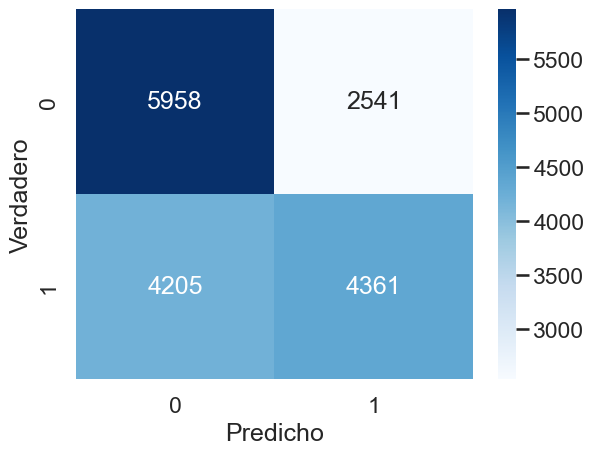

In [80]:
if not exists('modelos/clf_poly_no_optimizado.joblib'):

    #Creo un clasificador con kernel polinomico y lo entreno sobre los datos
    clf_poly_no_optimizado = SVC(kernel='poly', random_state=9)
    clf_poly_no_optimizado.fit(x_train, y_train)
    
    dump(clf_poly_no_optimizado, 'modelos/clf_poly_no_optimizado.joblib')

else:
    clf_poly_no_optimizado = load('modelos/clf_poly_no_optimizado.joblib')

#Hago la predicción y calculo las métricas
y_pred_pol=clf_poly_no_optimizado.predict(x_test)
metricas(y_pred_pol,y_test)

Con el kernel polinomico sin parametros obtenemos un f1_score bastante malo (0,6). Intentamos optimizarlo a continuacion.

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      8499
           1       0.76      0.74      0.75      8566

    accuracy                           0.75     17065
   macro avg       0.75      0.75      0.75     17065
weighted avg       0.75      0.75      0.75     17065



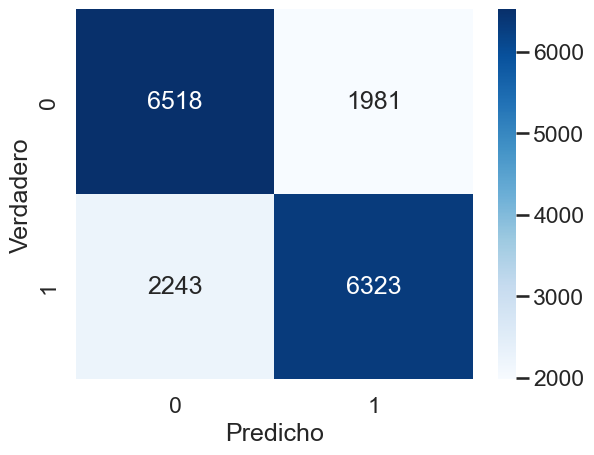

In [82]:
if not exists ('modelos/svm_poly_mejor_performance.joblib'):
    svm_poly_mejor_performance = SVC(kernel='poly', C=5, degree=1, gamma=1, coef0=1, random_state=9)
    svm_poly_mejor_performance.fit(x_train, y_train)
    
    dump(svm_poly_mejor_performance, 'modelos/svm_poly_mejor_performance.joblib')
else:
    svm_poly_mejor_performance = load('modelos/svm_poly_mejor_performance.joblib')
    
#Hago la predicción y calculo las métricas
y_pred_pol=svm_poly_mejor_performance.predict(x_test)
metricas(y_pred_pol,y_test)

Obtebemos que con valores de c=5, degree = 1, gamma =1 y coef01, el f1_score es de aproximadamente 0,75, parecido al lineal

Hacemos cross validation para ver que el modelo sea generalizable

#### ATENCION tarda 12 Min (sin archivos de joblib)

In [83]:
if not exists('modelos/svm_poly_mejor_performance.joblib'):
    folds=5

    kfoldcv = StratifiedKFold(n_splits=folds)
    scorer_fn = make_scorer(sk.metrics.f1_score)
    resultados = cross_validate(svm_poly_mejor_performance,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

    dump(resultados, 'modelos/resultados_cv_kernel_poly.joblib')
else:
    resultados = load('modelos/resultados_cv_kernel_poly.joblib')


In [84]:
metricsCV=resultados['test_score']
if not exists('modelos/svm_lineal_mejor_performance.joblib'):
    svm_poly_mejor_performance=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]
    dump(svm_poly_mejor_performance, 'modelos/svm_poly_mejor_performance.joblib')

metricsCV

array([0.74744198, 0.76092157, 0.7484476 , 0.74758023, 0.76054236])

Text(0.5, 1.0, 'Modelo entrenado con 5 folds')

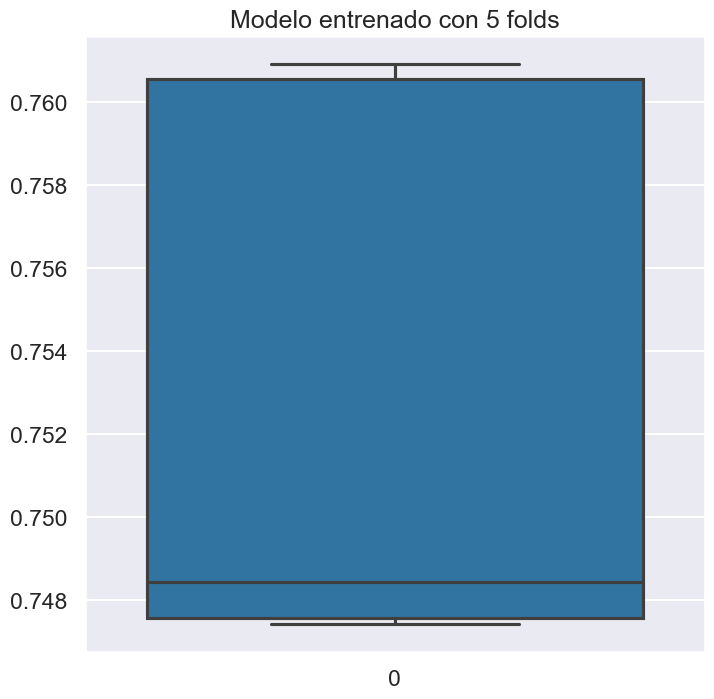

In [85]:
metric_labelsCV = ['F1 Score']*len(metricsCV) 
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(metricsCV)
plt.title("Modelo entrenado con 5 folds")

In [86]:
svm_poly_mejor_performance = load('modelos/svm_poly_mejor_performance.joblib')

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      8499
           1       0.76      0.74      0.75      8566

    accuracy                           0.75     17065
   macro avg       0.75      0.75      0.75     17065
weighted avg       0.75      0.75      0.75     17065

F1-Score: 0.7496147006520449


Text(37.08333333333333, 0.5, 'Verdadero')

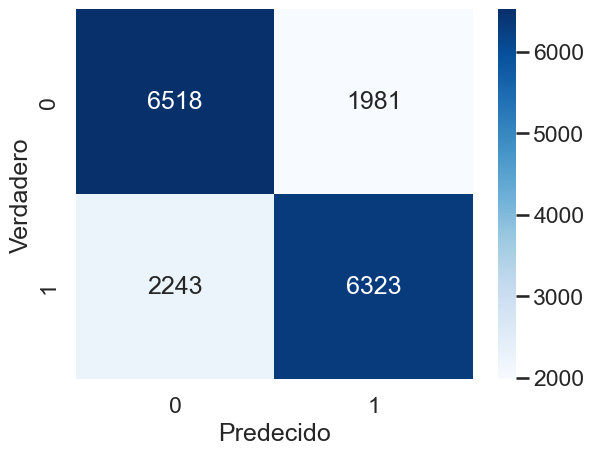

In [87]:
y_pred= svm_poly_mejor_performance.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) 
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predecido')
plt.ylabel('Verdadero')

Obtuvimos resultados bastante buenos (f1_score = 0,749)

Como conclusion del kernel polinomico podemos decir que es relativamente bueno ya que se obtienen buenos valores de f1_socre (). Sin embargo consideramos que apelar a un Kernerl con esta complejidad para obtener resultados muy parecidos al lineal no es rentable. 
#### Mantenemos al kernel lineal como el mejor hasta el momento

#### Kernel radial

**ATENCION: 5 MIN con core i5 + 16Gb RAM (sin archivos de joblib)**

In [142]:
if not exists('modelos/clf_radial_no_optimizado.joblib'):

    #Creo un clasificador con kernel radial y lo entreno
    clf_radial_no_optimizado = SVC(kernel='rbf', random_state=9)
    clf_radial_no_optimizado.fit(x_train, y_train)

    dump(clf_radial_no_optimizado, 'modelos/clf_radial_no_optimizado.joblib')

else:
    clf_radial_no_optimizado = load('modelos/clf_poly_no_optimizado.joblib')

#Hago la predicción y calculo las métricas
y_pred_rad=clf_radial_no_optimizado.predict(x_test)
metricas(y_pred_rad,y_test)

TypeError: 'list' object is not callable

Obtenemos resultados bastante malos de f1_score (0,6)

#### Intentamos mejorar los parametros del SVM con kernel raidal haciendo una busquedo con GridSearch.

**ATENCION: 2 MIN con core i5 + 16Gb RAM (sin archivos de joblib)**

In [89]:
if not exists('modelos/gridcv_svm_kernel_radial.joblib'):

    parametros = {'C': [1, 9, 10, 100],
    'gamma': [0, 10, 100],
    'class_weight':['balanced', None]}

    #vario hiperparaemtros en kernel polinomico
    clf_rbf = SVC(kernel ="rbf", cache_size=900, max_iter=100, random_state=9)
    #SVC(kernel='poly', C=5, degree=10, gamma=10, coef0=10)
    #clf.fit(x_train, y_train)
    combinaciones=10

    scorer_fn = make_scorer(sk.metrics.f1_score)

    #svmReg = svm.SVR(cache_size=900, max_iter=1000) # El cache es para agilizar el procesado
    # Ademas se limita a 1000 max iter dado que de otra forma el procesamiento tarda demasiado.


    gridcv_svm_kernel_radial = GridSearchCV(estimator=clf_rbf,
                                param_grid= parametros,
                                #param_distributions = parametros,
                                scoring=scorer_fn,
                                #cv=kfoldcv,
                                #n_iter=combinaciones
                                ) 

    #lo entreno sobre los datos
    gridcv_svm_kernel_radial.fit(x_train, y_train)

    dump(gridcv_svm_kernel_radial, 'modelos/gridcv_svm_kernel_radial.joblib')

else:
    gridcv_svm_kernel_radial = load('modelos/gridcv_svm_kernel.joblib')

#con o sin el archivo joblib...
print("Mostramos los mejores resultados: ")
print(gridcv_svm_kernel_radial.best_params_)
print()
print("Mostramos el mejor resultado obtenido de busqueda aleatoria: ")
print("f1_score: ",gridcv_svm_kernel_radial.best_score_)

Mostramos los mejores resultados: 
{'kernel': 'linear'}

Mostramos el mejor resultado obtenido de busqueda aleatoria: 
f1_score:  0.7532796371267546


Se oibtuvieron resultados de f1_score apenas mejores q en el caso anterior (0.67). No representan una mejora respecto al SVM creado por default.

A continuacion, creamos el SVM con ""mejores"" parametros y realizamos la prediccion. <br /> 

**ATENCION: 15 MIN con core i5 + 16Gb RAM (sin archivos de joblib)**<br />


In [90]:
if not exists('modelos/svm_kernel_radial_mejor.joblib'):

    mejor_svm_rbf = SVC().set_params(**gridcv_svm_kernel_radial.best_params_)
    mejor_svm_rbf.fit(x_train, y_train)
    dump(svm_lineal_mejor_performance, 'modelos/svm_kernel_radial_mejor.joblib')

else:
    mejor_svm_rbf = load('modelos/svm_kernel_radial_mejor.joblib')



**2 minutos toma lo que sigue**

              precision    recall  f1-score   support

           0       0.65      0.99      0.78      8499
           1       0.98      0.47      0.64      8566

    accuracy                           0.73     17065
   macro avg       0.81      0.73      0.71     17065
weighted avg       0.82      0.73      0.71     17065



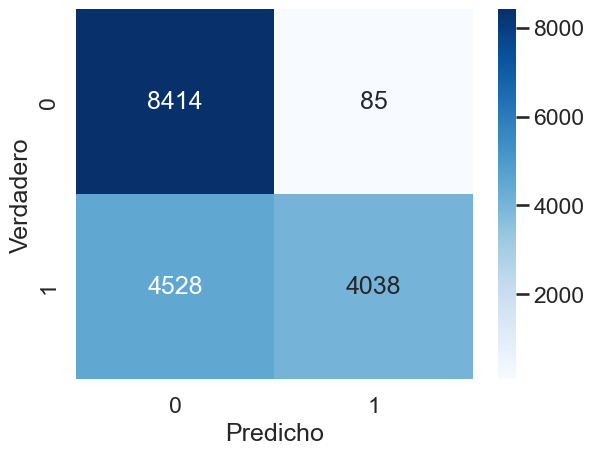

In [91]:
y_pred_rad_mejorado=mejor_svm_rbf.predict(x_test)
metricas(y_pred_rad_mejorado,y_test)

Podemos ver que las metricas mejoraron sustancialmente pero no supera el f1_score de 0,75 alcanzado con el kernels lineal/ polinomico. Ademas existe cierto sesgo ya que el modelo tiene mayor capacidad para predecir la clase 1 sobre la clase 0.

A pesar de ello...

##### Hacemos Cross validation con el svm radial con mejores paraemetros encontrado.
**El siguiente codigo se encuentra comentado ya que no pudimos terminar de correrlo debido al tiempo que toma (minimo 35 minutos con core i5 y 16Gb RAM)**


In [92]:
# if not exists('moswloa/svm_kernel_radial_mejor.joblib'):

#     folds=5

#     kfoldcv = StratifiedKFold(n_splits=folds)
#     scorer_fn = make_scorer(sk.metrics.f1_score)
#     resultados = cross_validate(mejor_svm_rbf,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

#     metricsCV=resultados['test_score']

#     clf_poly_no_optimizado=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]
    

#     metricsCV

Al no poder terminar de correr cross validation no podemos afirmar que el modelo con Kernel radial sea generalizable. En caso de que lo fuere, posee un score bajo (f1_score =0,73) respecto a los otros kernels y por si fuera poco se encuentra sesgado como se dijo mas arriba.<br />
**Se descarta para su utilizacion en el ensmable**.

## Conclusion SVM
Con lo visto en clase, las pruebas hechas durante la realizacion del tp, lo googleado, lo Chatgetepeado Y lo BARDeado (AI de google en prueba) se concluye que al trabjar con una cantidad tan grande de datos de testeo lo mejor es utilzar un Kernel lineal(ver primera seccion de SVM). Este sera el utilizado para el ensable en su correspondiente seccion.

# Random Forest 

Para empezar con el random forest, vamos a crear un modelo con valores totalmente aleatorios.
Usando https://www.random.org/, con valor maximo 50 y valor minimo 1, obtuvimos:
- 33
- 15
- 40
- 36

(Criterion fue dejado como entropy)

In [93]:
if exists('modelos/randomForest.joblib') == False:
    #Creamos un clasificador con hiperparámetros arbitrarios
    rfc = RandomForestClassifier(max_features='auto', 
                                 n_jobs=JOBS,
                                 criterion="entropy", 
                                 random_state=SEED, 
                                 min_samples_leaf=15,
                                 min_samples_split=40,
                                 n_estimators=36 )
    #Entrenamos el modelo
    model = rfc.fit(X = x_train, y = y_train)
    
    #Nos guardamos este modelo para poder cargarlo en todas las corridas posteriores
    dump(model, 'modelos/randomForest.joblib')

In [94]:
model = load('modelos/randomForest.joblib')

In [95]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

array([0, 1, 1, ..., 0, 0, 0])

La matriz de confusion es la siguiente:

Text(37.08333333333333, 0.5, 'Verdadero')

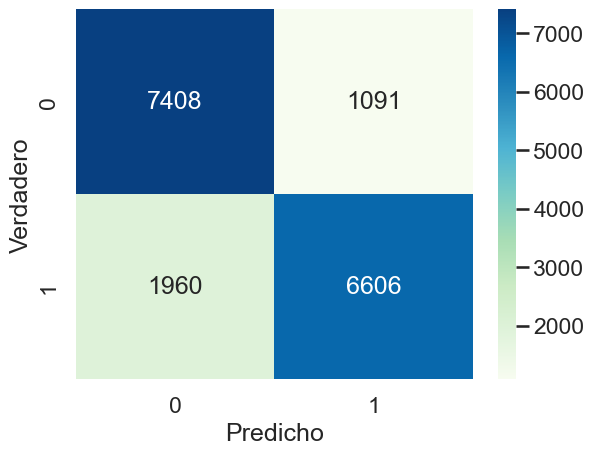

In [96]:
#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

Vemos que obtuvimos una alta cantidad de falsos positivos

Sin ningun tipo de optimizacion obtuvimos los siguientes scores 

In [97]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.8212130090829183
Recall: 0.7711884193322438
f1 score: 0.8123962368566686


Ademas, segun este modelo; las 10 columnas mas relevantes son:

In [98]:
p = sorted(list(zip(hotelsdf_modelo_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])
for i in range(10):
    print(p[i])

('deposit_type_Non Refund', 0.18176429502637184)
('lead_time', 0.12680811870190134)
('special_requests_num', 0.09015610070004025)
('previous_cancellations_num', 0.07709769614690201)
('required_car_parking_spaces_num', 0.062427027402470255)
('agent_id', 0.04805856247381744)
('average_daily_rate', 0.038159077209816754)
('customer_type_Transient', 0.0372242729020912)
('market_segment_type_Groups', 0.03160289854665912)
('market_segment_type_Online TA', 0.0284745604278098)


Vamos a hacer un submission de nuestro random forest aleatorio:

In [99]:
y_pred = model.predict(hotelsdf_pruebas)

In [100]:
df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': y_pred})
df_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [101]:
df_submission.to_csv('submissions/random_forest_random.csv', index=False)

Este modelo tuvo el siguiente resultado en Kaggle
![randoForest](informe/images/randomForest_random.png)

## Cross validation

Ahora vamos a buscar mejorar esos resultados; optimizando los hiperparametros usando validacion cruzada

In [102]:
if exists('modelos/randomForestCV.joblib') == False:
    rf_cv = RandomForestClassifier(oob_score=False, random_state=9, n_jobs=JOBS)
    #rf_cv = RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=1, n_jobs=-1)
    param_grid = { "criterion" : ["gini", "entropy"], 
                   "min_samples_leaf" : [1, 5, 10, 15, 20], #Vamos a hacer muchas combinaciones ya que solo vamos
                   "min_samples_split" : [2, 8, 16, 32, 64],#a correr este modelo 1 sola vez; ya que lo vamos a 
                   "n_estimators": [10, 20, 30, 40, 50, 60, 70] } #guardar   

    #Probamos entrenando sólo con 1 métrica
    gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="f1", cv=5, n_jobs=JOBS) #Optimizamos f1_score
    gs_fit = gs.fit(X = x_train, y = y_train)
    dump(gs_fit, 'modelos/randomForestCV.joblib')

In [103]:
gs_fit = load('modelos/randomForestCV.joblib')

In [104]:
gs_fit.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 60}

In [105]:
#Obtenemos el mejor modelo
rf_cv_best=gs_fit.best_estimator_

#Predicción
y_pred_rf_cv_best = rf_cv_best.predict(x_test)
y_pred_rf_cv_best

array([0, 1, 1, ..., 0, 0, 0])

Con esta validacion, obtenemos la siguiente matriz de confusion

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      8499
           1       0.86      0.82      0.84      8566

    accuracy                           0.84     17065
   macro avg       0.85      0.84      0.84     17065
weighted avg       0.85      0.84      0.84     17065



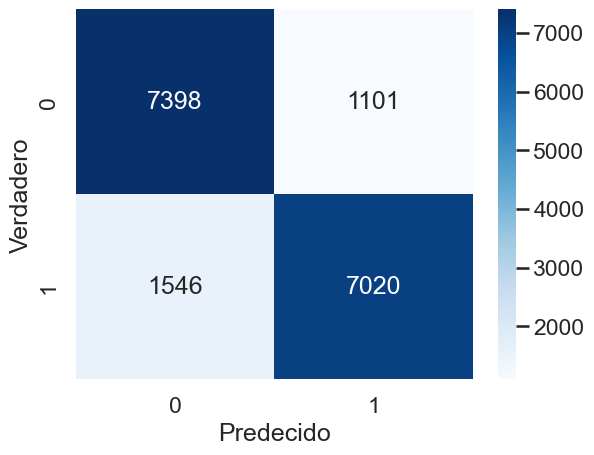

In [106]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_rf_cv_best)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predecido')
plt.ylabel('Verdadero')

#Reporte
print(classification_report(y_test,y_pred_rf_cv_best))

A priori, se ven menos falsos positivos

In [107]:
#Evaluo la performance en el conjunto de evaluación
accuracyCV=accuracy_score(y_test,y_pred_rf_cv_best)
recallCV=recall_score(y_test,y_pred_rf_cv_best)
f1CV=f1_score(y_test,y_pred_rf_cv_best)

print("Accuracy: "+str(accuracyCV))
print("Recall: "+str(recallCV))
print("f1 score: "+str(f1CV))

Accuracy: 0.8448871960152359
Recall: 0.8195190287181882
f1 score: 0.8413735243003535


Con este nuevo modelo, obtuvimos las siguientes mejoras:

In [108]:
print(str("Accuracy = ") + str(accuracyCV - accuracy)[3:4] + "%")
print(str("Recall = ") + str(recallCV - recall)[3:4] + "%")
print(str("f1 score = ") + str(f1CV - f1)[3:4] + "%")

Accuracy = 2%
Recall = 4%
f1 score = 2%


Vemos que optimizando por el f1 score, obtuvimos una mejora del 2% nada mas; pero una mejora del 4% en recall

Vamos a realizar una submission de este modelo

In [109]:
y_pred_model_rfcv = rf_cv_best.predict(hotelsdf_pruebas)

In [110]:
df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': y_pred_model_rfcv})
df_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [111]:
df_submission.to_csv('submissions/random_forestCV.csv', index=False)

Este modelo tuvo el siguiente resultado en Kaggle
![randoForestCVMM](informe/images/randomForestCV.png)

## Cross validation multiples metricas

Ahora vamos a realizar un random forest pero tratando de optimizar distintas metricas a la vez. \
Luego vamos a elegir la que optimice mejor todas las metricas

In [112]:
#Metricas que vamos a analizar:
metricas=['accuracy','f1','roc_auc' ,'recall', 'precision'] 

if exists('modelos/randomForestCVMM.joblib') == False:
    rf_cv = RandomForestClassifier(oob_score=False, random_state=1, n_jobs=JOBS)

    param_grid = { "criterion" : ["gini", "entropy"], 
                    "min_samples_leaf" : [1, 5, 10, 15, 20], #Vamos a hacer muchas combinaciones ya que solo vamos
                    "min_samples_split" : [2, 8, 16, 32, 64],#a correr este modelo 1 sola vez; ya que lo vamos a 
                    "n_estimators": [10, 20, 30, 40, 50, 60, 70] } #guardar   


    gs_multimetrica = GridSearchCV(estimator=rf_cv, 
                                   param_grid=param_grid, 
                                   scoring=metricas, 
                                   refit=False, 
                                   cv=5, 
                                   n_jobs=JOBS)
    #Entrenamiento
    gs_multimetrica_fit = gs_multimetrica.fit(X = x_train, y = y_train)
    dump(gs_multimetrica_fit, 'modelos/randomForestCVMM.joblib')

In [113]:
gs_multimetrica_fit = load('modelos/randomForestCVMM.joblib')

Vamos a graficar todos los resultados de las metricas que medimos

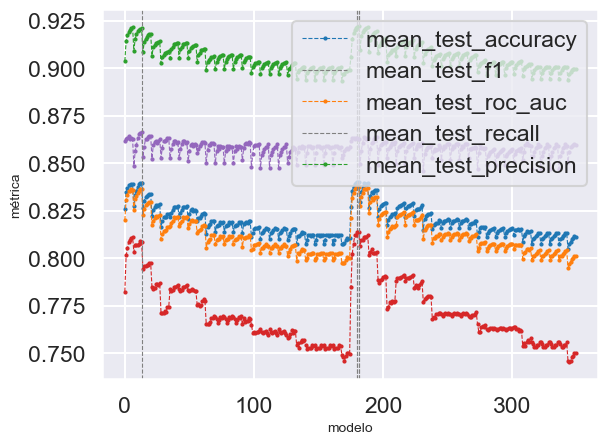

In [114]:
labels=[ key for key in gs_multimetrica_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_multimetrica_fit.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)     
    x_linea=np.argmax(gs_multimetrica_fit.cv_results_[k])
    plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey')
        
plt.xlabel("modelo", fontsize=10)
plt.ylabel("métrica", fontsize=10)
plt.legend(labels)
plt.show()

Del grafico se observa que hay un modelo que parece optimizar todas las metricas. A ojo parece ser el ~180\
Vamos a corroborarlo:

In [115]:
for metrica in metricas:
    params_analizar=gs_multimetrica_fit.cv_results_['params'][np.argmax(gs_multimetrica_fit.cv_results_['mean_test_' + metrica])]
    print(
"Metrica " + metrica + ": " + str(params_analizar))

Metrica accuracy: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}
Metrica f1: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}
Metrica roc_auc: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
Metrica recall: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
Metrica precision: {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 70}


Vemos que son todos muy similares pero con cierta variazon. Vamos a elegir a f1 score para tener cierto tipo de balance

In [116]:
params_elegidos=gs_multimetrica_fit.cv_results_['params'][np.argmax(gs_multimetrica_fit.cv_results_['mean_test_f1'])]

#Creamos un clasificador RF
rfc_multimetrica = RandomForestClassifier(criterion= params_elegidos['criterion'], 
                                          min_samples_leaf= params_elegidos['min_samples_leaf'], 
                                          min_samples_split= params_elegidos['min_samples_split'], 
                                          n_estimators=params_elegidos['n_estimators'], 
                                          oob_score=True, random_state=2, n_jobs=JOBS)
#Entrenamos un modelo
model_rfc_multimetrica = rfc_multimetrica.fit(X = x_train, y = y_train)

#Hacemos una predicción con el dataset de train
y_pred_model_rfc_multimetrica = model_rfc_multimetrica.predict(x_test)

Vamos a visualizar uno de los estimadores de este random forest resultante:

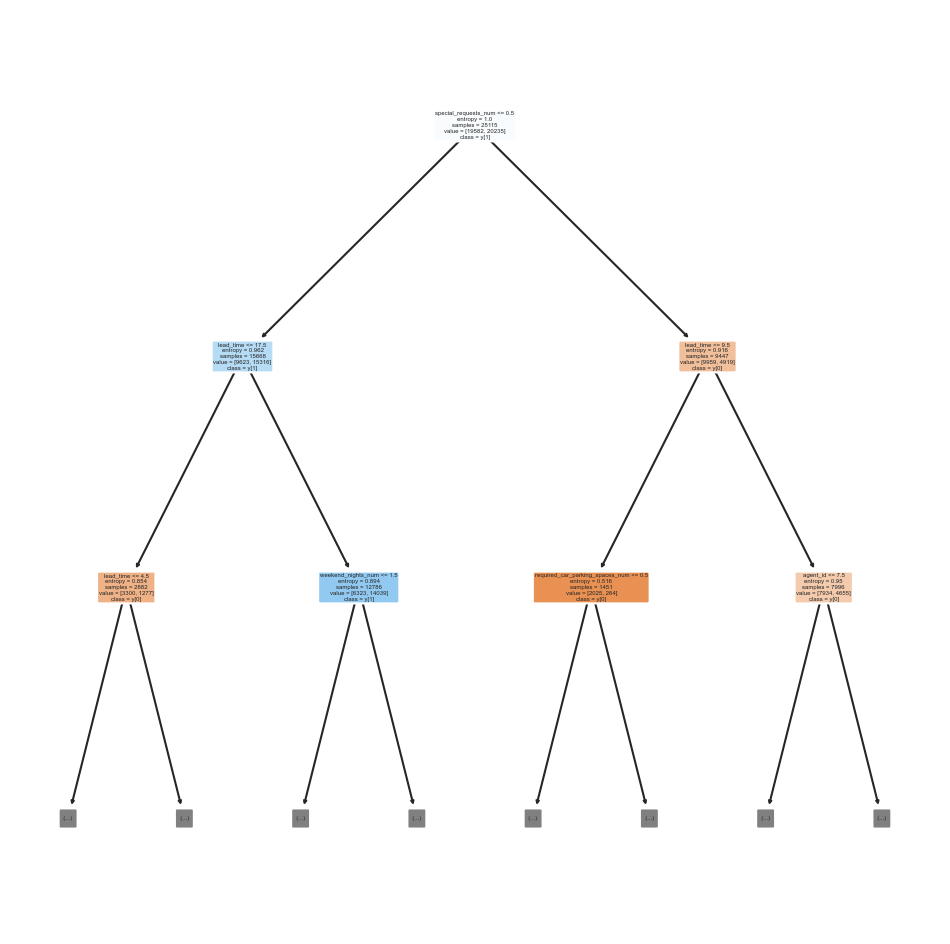

In [117]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(rfc_multimetrica.estimators_[56],
                         max_depth=2,
                         feature_names=hotelsdf_modelo_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

Vision completa:

Calculamos la matriz de confusion

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      8499
           1       0.86      0.82      0.84      8566

    accuracy                           0.85     17065
   macro avg       0.85      0.85      0.85     17065
weighted avg       0.85      0.85      0.85     17065



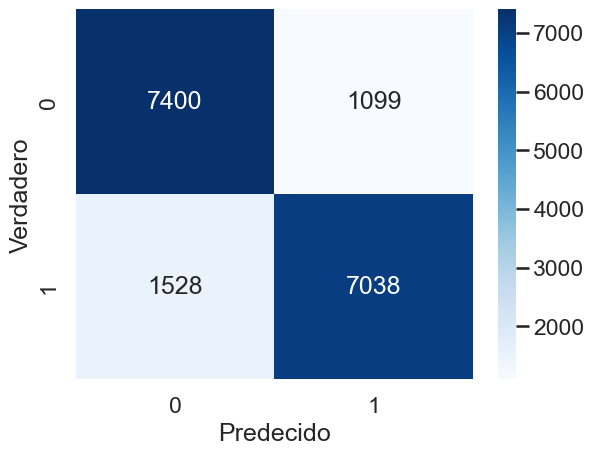

In [118]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_model_rfc_multimetrica)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predecido')
plt.ylabel('Verdadero')

#Reporte
print(classification_report(y_test,y_pred_model_rfc_multimetrica))


A pesar de todas nuestra busqueda, no se observan cambios significativos

In [119]:
#Evaluo la performance en el conjunto de evaluación
accuracyCVMM=accuracy_score(y_test,y_pred_model_rfc_multimetrica)
recallCVMM=recall_score(y_test,y_pred_model_rfc_multimetrica)
f1CVMM=f1_score(y_test,y_pred_model_rfc_multimetrica)

print("Accuracy: "+str(accuracyCVMM))
print("Recall: "+str(recallCVMM))
print("f1 score: "+str(f1CVMM))

Accuracy: 0.8460591854673308
Recall: 0.8216203595610553
f1 score: 0.8427228641561396


Sorprendentemente, no tuvimos mejoras significativas comparado con el modelo que no consideraba todas las metricas

In [120]:
print(str("Accuracy = ") + str(accuracyCVMM - accuracyCV)[3:4] + "%")
print(str("Recall = ") + str(recallCVMM - recallCV)[3:4] + "%")
print(str("f1 score = ") + str(f1CVMM - f1CV)[3:4] + "%")

Accuracy = 0%
Recall = 0%
f1 score = 0%


Realizamos la prediccion sobre el dataset de testeo

In [121]:
y_pred_model_rfc_multimetrica = model_rfc_multimetrica.predict(hotelsdf_pruebas)

In [122]:
df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': y_pred_model_rfc_multimetrica})
df_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [123]:
df_submission.to_csv('submissions/random_forestCVMM.csv', index=False)

Este modelo tuvo el siguiente resultado en Kaggle
![randoForestCVMM](informe/images/randomForestCVMM.png)

Vemos que a pesar de todas nuestras mejoras, solo obtuvimos una mejora del 0.2%

# XGBoost 

## Modelo base

Generamos un modelo XGBoost base, con los hiperparametros por defecto, de manera que se pueda realizar una comparacion posterior a entrenar un modelo con sus hiperparametros optimmizados

In [124]:
if not exists('modelos/xgb_base.joblib'):
    xgb_base = xgb.XGBClassifier(random_state=9, n_estimators=100) 
    xgb_base.fit(x_train, y_train)
    dump(xgb_base, 'xgb_base.joblib')
else:
    xgb_base = load('modelos/xgb_base.joblib')

Vemos el comportamiento del modelo base y mostramos las metricas obtenidas en el procesp

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      8499
           1       0.85      0.81      0.83      8566

    accuracy                           0.83     17065
   macro avg       0.84      0.83      0.83     17065
weighted avg       0.84      0.83      0.83     17065

F1-Score: 0.8315506423662983


Text(37.08333333333333, 0.5, 'Verdadero')

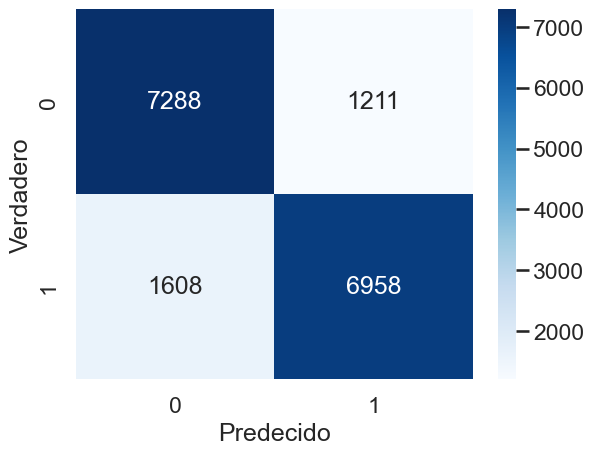

In [125]:
y_pred = xgb_base.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) 
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predecido')
plt.ylabel('Verdadero')

Realizamos una prediccion para kaggle y almacenamos el modelo generado en una primera instancia 

In [126]:
y_pred = xgb_base.predict(hotelsdf_pruebas)
y_pred
df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': y_pred})

if not exists('submissions/xgb_base.csv'):
    df_submission.to_csv('xgb_base.csv', index=False)

Destacamos que este modelo sin recibir ninguna optimización tiene la presición mas alta de todos los modelos entrenados

## Busqueda de hiperparametros

Realizamos una busqueda para encontrar los mejores hiperparametros del XGBoost y a su vez optimizar el modelo *Puede tomar tiempo, alrededor de 50 min*

In [127]:
if not exists('modelos/RCV_xgb.joblib'):

    estimadores = [90, 100, 110, 150]
    profundidad_max = [7, 8, 9, 10, 15]
    learning_rate = [0.01, 0.05, 0.1, 0.2]

    params = {
        'max_depth': profundidad_max,
        'n_estimators': estimadores,
        'learning_rate': learning_rate,
            }


    xgb_entrenamiento = xgb.XGBClassifier()
    combinaciones = 10
    k_folds = 10
    metrica_fn = make_scorer(sk.metrics.f1_score)

    parametros = RandomizedSearchCV(
                estimator=xgb_entrenamiento, 
                param_distributions = params, 
                cv=k_folds, 
                scoring=metrica_fn, 
                n_iter=combinaciones, 
                random_state=9)

    parametros.fit(x_train, y_train)
    parametros.cv_results_['mean_test_score']

    dump(parametros, 'modelos/RCV_xgb.joblib')

else:
    parametros = load('modelos/RCV_xgb.joblib')

Mostramos las metricas y los mejores hiperparametros conseguidos en el analisis 

In [128]:
print("Mostramos los mejores resultados: ")
print(parametros.best_params_)
print()
print("Mostramos el mejor resultado obtenido de busqueda aleatoria: ")
print("f1_score = ",parametros.best_score_)

Mostramos los mejores resultados: 
{'n_estimators': 110, 'max_depth': 15, 'learning_rate': 0.1}

Mostramos el mejor resultado obtenido de busqueda aleatoria: 
f1_score =  0.8452418111003613


Entrenamos el modelo con sus hiperparametros

In [129]:
if not exists('modelos/xgb_optimizado.joblib'):
    xgb_optimizado = xgb.XGBClassifier(**parametros.best_params_)
    xgb_optimizado.fit(x_train, y_train)
else:
    xgb_optimizado = load('modelos/xgb_optimizado.joblib')

Realizamos la validación cruzada del modelo para verificar que no caiga en overfitting o underfitting 

In [130]:
kfoldcv =StratifiedKFold(n_splits=k_folds) 
resultados_xgb = cross_validate(xgb_optimizado,x_train, y_train, cv=kfoldcv,scoring=metrica_fn,return_estimator=True)
metricas_xgb = resultados_xgb['test_score']
xgb_optimizado = resultados_xgb['estimator'][np.where(metricas_xgb==max(metricas_xgb))[0][0]]

Observamos el comportamiento del modelo a lo largo de la validacón cruzada 

Text(0.5, 1.0, 'Modelo entrenado con 10 folds')

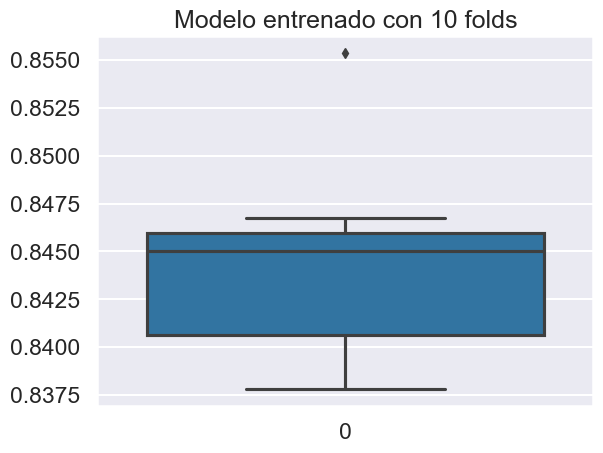

In [131]:
metric_labelsCV = ['F1 Score']*len(metricas_xgb) 
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure()
sns.boxplot(metricas_xgb)
plt.title("Modelo entrenado con 10 folds")

Observamos la matriz de confusión del modelo y concluimos que es el modelo con el mejor F1 score que se ha podido entrenar en el analisis sobre las reservas

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      8499
           1       0.85      0.83      0.84      8566

    accuracy                           0.84     17065
   macro avg       0.84      0.84      0.84     17065
weighted avg       0.84      0.84      0.84     17065

F1-Score: 0.8411093371178523


Text(37.08333333333333, 0.5, 'verdadero')

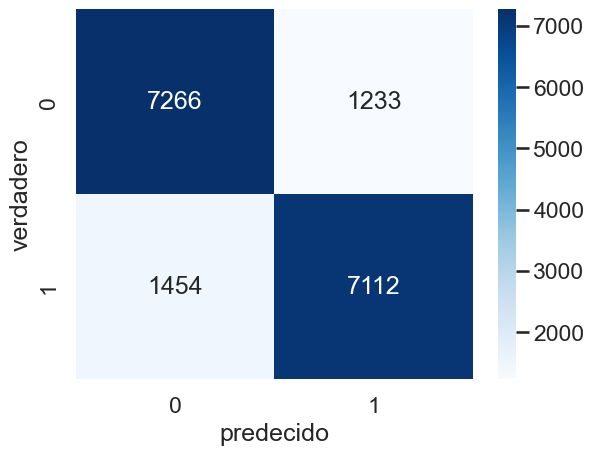

In [132]:
y_pred= xgb_optimizado.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) 
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('predecido')
plt.ylabel('verdadero')

Realizamos la predicción de kaggle 

In [133]:
if not exists('submissions/xgb_optimizado.joblib'):
    y_pred = xgb_optimizado.predict(hotelsdf_pruebas)
    df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': y_pred})
    df_submission.to_csv('submissions/xgb_optimizado.csv', index=False)

El ensamble XGBoost representa el modelo más preciso de todos los modelos entrenados hasta esta sección del analisis

# Modelo Voting

In [134]:
#anadir if cuando este list
if not exists('modelos/voting.joblib.gz'): #Tenemos el archivo comprimido porque era muy grande
    knn_clf = knn_optimizado #Knn
    svm_clf = mejor_svm_rbf #SVM
    rf_clf = model_rfc_multimetrica #Random Forest
    xgb_clf = xgb_optimizado #XGBoost

    #Creo ensemble de Votación
    vot_clf = VotingClassifier(estimators = [('knn', knn_clf), ('svm', svm_clf), ('rf', rf_clf), ('xgb', xgb_clf)], voting = 'hard', n_jobs=JOBS)

    #Entreno el ensemble
    vot_clf.fit(x_train, y_train)

    #Evaluo en conjunto de test
    pred = vot_clf.predict(x_test)
    accuracy_score(y_test, pred)
    dump(vot_clf, 'modelos/voting.joblib')
    !gzip modelos/voting.joblib #Comprimimos

else:
    !gzip -d -k modelos/voting.joblib.gz #Descomprimimos
    vot_clf = load('modelos/voting.joblib')
    !rm modelos/voting.joblib

In [135]:
if not exists('submissions/voting.csv'):
    y_pred = vot_clf.predict(hotelsdf_pruebas)
    df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': y_pred})
    df_submission.to_csv('submissions/voting.csv', index=False)

Vamos a quitar el SVM del ensamble ya que nos dio malos resultados. Ademas, vamos a cambiar el tipo de voting de hard a soft, para tener una votacion ponderada

In [136]:
#anadir if cuando este list
if not exists('modelos/votingNoSvmSoft.joblib.gz'):
    knn_clf = knn_optimizado #Knn
    rf_clf = model_rfc_multimetrica #Random Forest
    xgb_clf = xgb_optimizado #XGBoost

    #Creo ensemble de Votación
    vot_clf = VotingClassifier(estimators = [('knn', knn_clf), ('rf', rf_clf), ('xgb', xgb_clf)], voting = 'soft', n_jobs=JOBS)

    #Entreno el ensemble
    vot_clf.fit(x_train, y_train)

    #Evaluo en conjunto de test
    pred = vot_clf.predict(x_test)
    accuracy_score(y_test, pred)
    dump(vot_clf, 'modelos/votingNoSvmSoft.joblib')
    !gzip modelos/votingNoSvmSoft.joblib #Comprimimos

else:
    !gzip -d -k modelos/votingNoSvmSoft.joblib.gz #Descomprimimos
    vot_clfNoSvmSoft = load('modelos/votingNoSvmSoft.joblib')
    !rm modelos/votingNoSvmSoft.joblib
    

In [137]:
if not exists('submissions/votingNoSvmSoft.csv'):
    y_pred = vot_clf.predict(hotelsdf_pruebas)
    df_submission = pd.DataFrame({'id': hotelsdf_pruebasOriginal['id'], 'is_canceled': y_pred})
    df_submission.to_csv('submissions/votingNoSvmSoft.csv', index=False)

# Modelo Stacking 

Generamos un modelo stacking usando los modelos previamente entrenados, de manera que sabemos que los modelos bases usados no sufren de overfitting o underfitting, utilizamos un regresor lineal como modelo de decisión para agreagr dinamismo al analisis 

In [138]:
modelos_base = [('knn', knn_optimizado),
               ('xgboost', xgb_optimizado),
               ('rf', rfc_multimetrica)]

modelo_final = LogisticRegression()

stacking_model = StackingClassifier(estimators=modelos_base, 
                                    final_estimator=modelo_final, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)


Una vez generado el modelo, lo entrenamos y observamos su comportamiento general con los datos de train 

In [139]:
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)
accuracy_score(y_test, y_pred_st)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished


0.8035745678288896

Mostramos la matriz de confusión del modelo y mostramos su metrica F1

F1-Score: 0.8013276434329065


Text(37.08333333333333, 0.5, 'Verdadero')

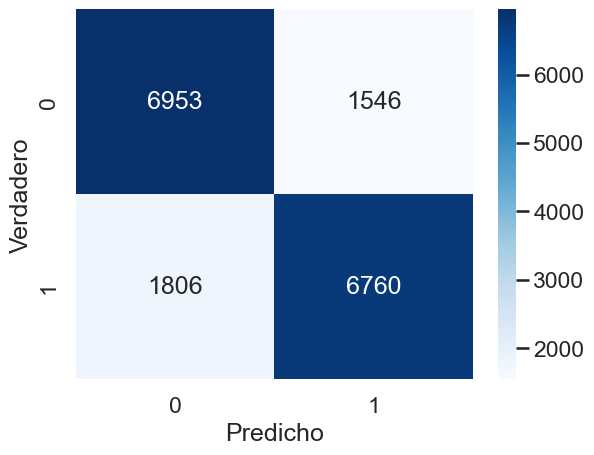

In [140]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred_st, average='binary'))) 
confusion_voting = confusion_matrix(y_test, y_pred_st)
sns.heatmap(confusion_voting, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

Podemos concluir que el modelo no representa una mejora considerable a los modelos anteriormente entrenamos y que forman parte del ensamble creado 

# Conclusiones 

1. KNN: 
    El modelo knn no genera una mejora sustancial del modelo anteriormente entrenado. Por otro lado, es el modelo que en comparación mejora considerablemente al comparar con la version base del mismo, el modelo con ajustes de hiperparametros escala aproximadamente 0.05 en relación al base

2. SVM:
    El modelo SVM con sus diferentes kernels posibles es el modelo con el menor desempeño de todos los modelos entrenados hasta el momento, sin embargo es comparable en eficacia con el KNN, aunque la desventaja es que sus tiempos de entrenamiento son muchisimo mayores 

3. Random Forest:
    El primer ensamble del analisism, entre todas las instancias generadas del modelo obtuvimos una predicción de la misma magnitud que con el árbol

4. XGBoost:
5. Voting:
6. Stacking:
7. General